# Relationship Analysis & Feature Vetting for Machine Learning

This notebook focuses on how variables relate to each other and how those relationships inform:
- Feature selection
- Model choice
- Data preprocessing decisions

We move beyond single-variable analysis and into:
- Pairwise relationships
- Correlation structure
- Group comparisons
- Statistical significance
- Practical significance (effect size)
- Feature usefulness for classification

This is the bridge between Exploratory Data Analysis (EDA) and Modeling.


In [46]:
#load in libraries and data sets
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats # statistics machine
df = pd.read_csv("Music_Data.csv")


## Scatterplots (Form, Direction, Strength, Linearity)

We use scatterplots to visually assess:
- Form (linear, curved, clustered, random)
- Direction (positive, negative, none)
- Strength (tight vs diffuse)
- Linearity (can we use linear models?)

If this relationship is roughly linear: Linear Regression is viable  
If curved: we should consider polynomial or tree-based models  
If cloud: weak predictive power

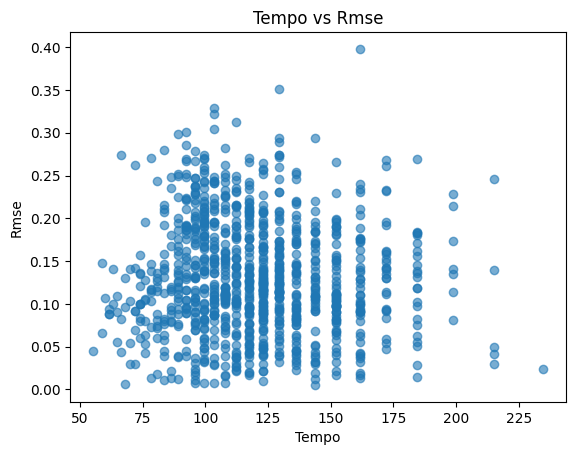

In [47]:
numeric_cols = df.select_dtypes(include="number").columns.tolist()
numeric_cols = [c for c in numeric_cols if c != "tempo"]  # avoid plotting tempo vs itself

y_col = "rmse" if "rmse" in df.columns else numeric_cols[0]

plt.figure()
plt.scatter(df["tempo"], df[y_col], alpha=0.6)
plt.xlabel("Tempo")
plt.ylabel(y_col.replace("_", " ").title())
plt.title(f"Tempo vs {y_col.replace('_',' ').title()}")
plt.show()


Pair plots allow us to quickly detect:
- Redundant features
- Strong relationships
- Completely uninformative features

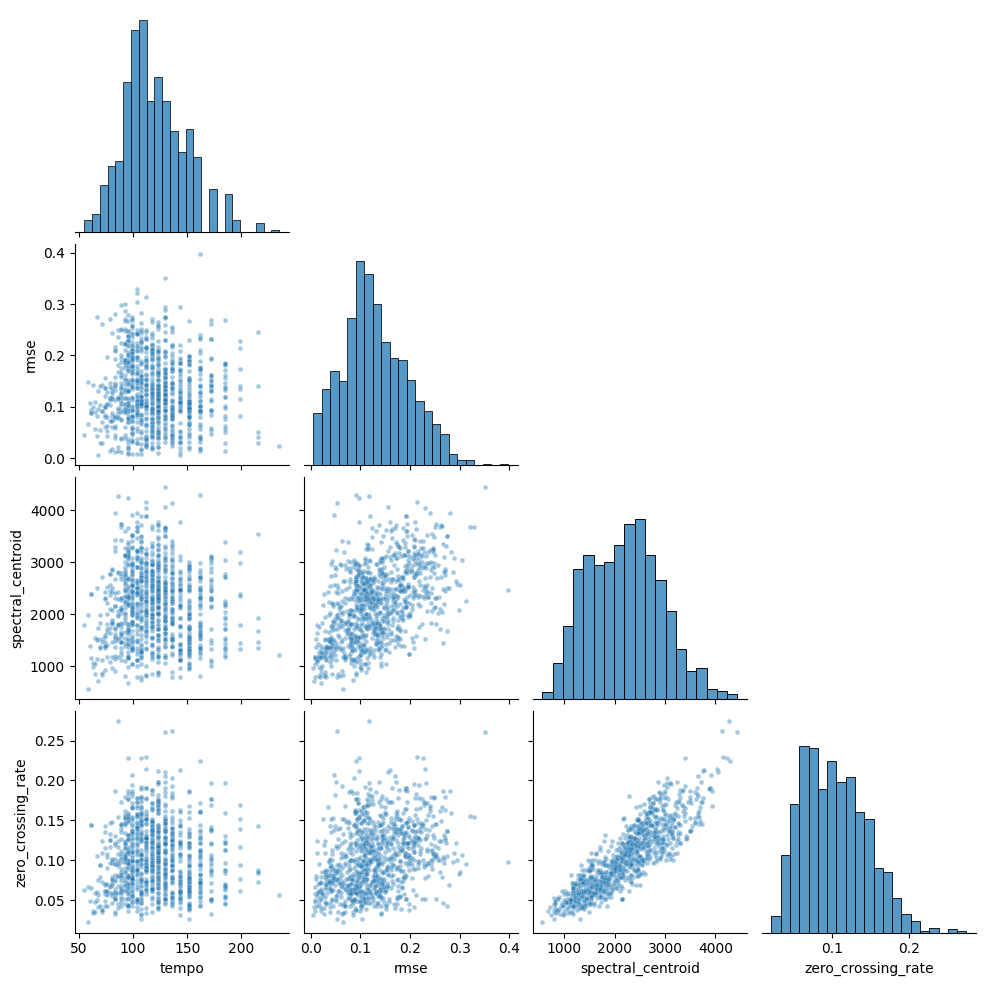

In [48]:
cols = ["tempo", "rmse", "spectral_centroid", "zero_crossing_rate"]

sns.pairplot(df[cols], corner=True, plot_kws={"alpha": 0.4, "s": 12})
plt.show()

Covariance shows whether two variables move together or in opposite directions.
However, because it depends on units, it is hard to interpret directly.
This is why we prefer correlation.

In [49]:
cov_matrix = df[["tempo", "rmse", "spectral_centroid", "zero_crossing_rate"]].cov()
cov_matrix

,tempo,rmse,spectral_centroid,zero_crossing_rate
tempo,800.741001,-0.080859,-292.042622,0.023599
rmse,-0.080859,0.004315,23.983593,0.000913
spectral_centroid,-292.042622,23.983593,512600.650081,26.200553
zero_crossing_rate,0.023599,0.000913,26.200553,0.001750


Highly correlated features (|r| > 0.9) often contain redundant information.
Keeping both can:
- Increase model complexity
- Increase overfitting risk

In practice, we often drop one.

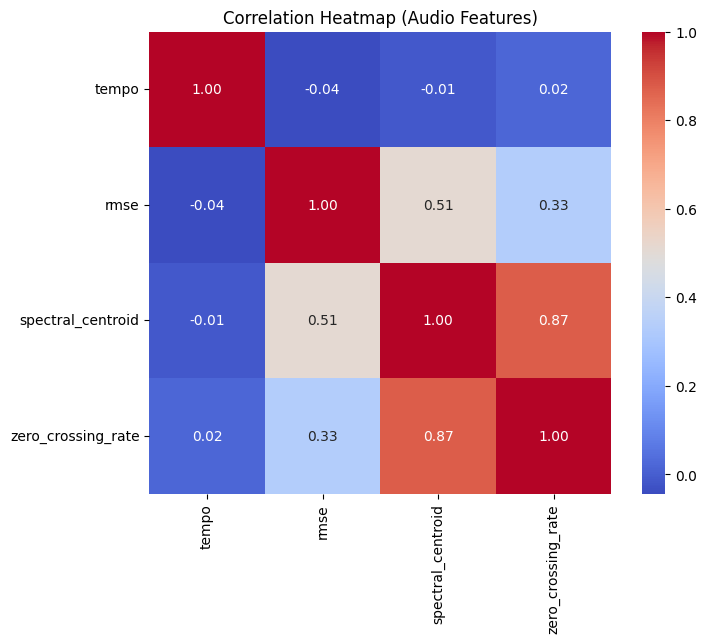

In [50]:
features = ["tempo", "rmse", "spectral_centroid", "zero_crossing_rate"]

corr_matrix = df[features].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap (Audio Features)")
plt.show()

This line represents the **baseline linear model**.
The vertical distances from each point to the line are **residuals**.
The algorithm's job is to minimize these.


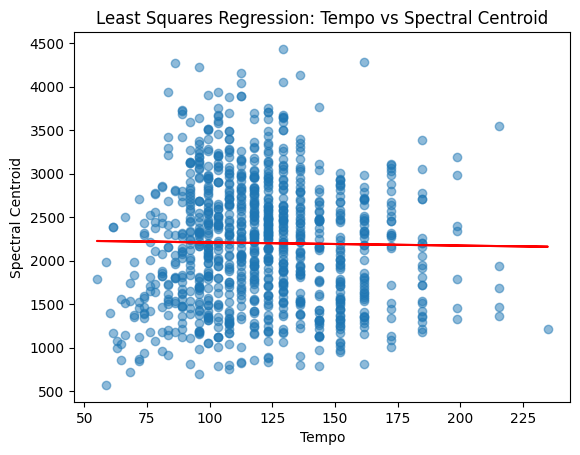

R-val:  0.00020778838105964964


In [51]:

x = df["tempo"]
y = df["spectral_centroid"]

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

plt.figure()
plt.scatter(x, y, alpha=0.5)
plt.plot(x, slope*x + intercept, color="red")
plt.xlabel("Tempo")
plt.ylabel("Spectral Centroid")
plt.title("Least Squares Regression: Tempo vs Spectral Centroid")
plt.show()

print("R-val: ", r_value**2)

- Genre is the target <br>
These are gut-check metrics.<br>
If differences are tiny → model will struggle.<br>
If differences are large → strong candidate feature.<br>

In [52]:

target_col = "label" # picj genre column
feature_col = "rmse" # pick any numeric feature you actually have

labels = df[target_col].astype(str).str.lower()
rock = df.loc[labels == "rock", feature_col].dropna()
jazz = df.loc[labels == "jazz", feature_col].dropna()

# mean diff
mean_diff = rock.mean() - jazz.mean()


#percentage change
eps = 1e-12
percent_change = (mean_diff / (jazz.mean() + eps)) * 100


#fold change
fold_change = (rock.mean() + eps) / (jazz.mean() + eps)

print("mean diff: ", mean_diff)
print("fold change: ", fold_change)
print("percentage change: ",  percent_change)


mean diff:  0.04066315773874522
fold change:  1.469220334380402
percentage change:  46.92203343804021


Interpretation:
- ~0.2 → small effect (weak feature)
- ~0.5 → medium effect
- ≥0.8 → large effect ("gold mine" feature)

In [53]:
def cohens_d(a, b):
    pooled_std = np.sqrt((np.std(a, ddof=1) ** 2 + np.std(b, ddof=1) ** 2) / 2)
    return (np.mean(a) - np.mean(b)) / pooled_std

d = cohens_d(rock, jazz)
print("d-val", d)


d-val 0.9078875550842326


## Hypothesis Testing – Is the Difference Real?

t-test (parametric)
- p < 0.05 → difference is statistically significant
- p ≥ 0.05 → difference may be noise

Mann-Whitney U (non-parametric)
- This test is safer for skewed, messy, real-world data (like audio features).

In [54]:
# t-test
t_stat, p_val = stats.ttest_ind(rock, jazz, equal_var=False)
t_stat, p_val
print("t-test", t_stat)
print("p-test", p_val)

#Mann-Whitney
u_stat, p_val_u = stats.mannwhitneyu(rock, jazz, alternative="two-sided")
u_stat, p_val_u
print("u-stat", u_stat)
print("p-val", p_val_u)

t-test 6.41973446754936
p-test 9.923871090244328e-10
u-stat 7577.0
p-val 3.066250379878827e-10


## ANOVA – Multi-Group Comparison
ANOVA checks if the variation between genres is larger than the variation within genres?<br>

If NO → this feature is likely noise. <br>
If YES → strong candidate feature.<br>

In [55]:
target_col = "label"
feature_col = "rmse"  # or "spectral_centroid", "mfcc1", etc.

groups = [
    group[feature_col].dropna().values
    for _, group in df.groupby(target_col)
]

f_stat, p_val = stats.f_oneway(*groups)
print("f stat", f_stat)
print("p val:", p_val)

f stat 74.07935063910945
p val: 2.019367440324564e-104


## Normalization – Preparing Fair Comparisons
Min-Max scaling puts all features on [0,1].
This allows us to:
- Compare them visually
- Prevent scale dominance in models

In [56]:
from sklearn.preprocessing import MinMaxScaler

features = ["tempo", "rmse", "spectral_centroid"]  # choose real numeric columns
scaler = MinMaxScaler()

scaled_features = scaler.fit_transform(df[features])

scaled_df = pd.DataFrame(
    scaled_features,
    columns=[f"{c}_scaled" for c in features]
)

scaled_df.head()


,tempo_scaled,rmse_scaled,spectral_centroid_scaled
0,0.268889,0.618702,0.400313
1,0.226337,0.275502,0.151673
2,0.539216,0.372502,0.196957
3,0.720238,0.289752,0.204713
4,0.592014,0.337256,0.321165


At this point, we can now:

- Eliminate deadweight features (no group difference, no correlation, no effect size)
- Remove redundant features (highly correlated)
- Prioritize high-signal features (large effect size + significant tests)
- Choose appropriate model families:
    - Linear relationships → Linear / Logistic Regression
    - Nonlinear relationships → Trees, SVM, Neural Nets
    - Weak separation → Expect lower ceiling performance

This step prevents:
- Garbage-in-garbage-out modeling
- Overfitting
- Wasted training time
- Misleading accuracy

In [57]:
target_col = "label"

# all numeric feature columns (drop obvious non-features)
feature_cols = df.select_dtypes(include="number").columns.tolist()
# (tempo, beats, chroma_stft, rmse, spectral_*, rolloff, zcr, mfcc1..mfcc20, etc.)

feature_scores = []

for col in feature_cols:
    groups = [
        g[col].dropna().values
        for _, g in df.groupby(target_col)
    ]

    # need at least 2 groups with data and non-empty arrays
    groups = [arr for arr in groups if len(arr) > 1]
    if len(groups) < 2:
        continue

    f_stat, p_val = stats.f_oneway(*groups)
    feature_scores.append((col, f_stat, p_val))

rank_df = pd.DataFrame(feature_scores, columns=["Feature", "F_statistic", "p_value"])
rank_df = rank_df.sort_values(by="F_statistic", ascending=False)

rank_df.head(15)

,Feature,F_statistic,p_value
2,chroma_stft,176.527723,6.759675e-199
8,mfcc1,130.208799,3.483411e-161
5,spectral_bandwidth,116.619321,9.612007e-149
6,rolloff,110.896033,2.781747e-143
4,spectral_centroid,97.494571,6.291865e-130
11,mfcc4,83.817516,2.147943e-115
9,mfcc2,83.197639,1.033445e-114
3,rmse,74.079351,2.019367e-104
15,mfcc8,67.486365,1.148835e-96
13,mfcc6,66.013366,6.777495e-95
